<a href="https://colab.research.google.com/github/MohamedAteya/Fashion-Mnist/blob/master/Mnist_fashion_kaggel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Load Data from kaggel

In [0]:
#!pip install kaggle
!mkdir .kaggle

#Kaggel account token
import json
token = {"username":"mohamedateya","key":"3bdace5f3ece4fe9ede9ed0262251284"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

#kaggel Datasets
!kaggle datasets list

#Data API
!kaggle datasets download -d zalando-research/fashionmnist -p /content --force

#unzip files...
!unzip \*.zip

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}
ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)    2GB  2020-05-13 22:21:42          67245  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                          142MB  2020-04-29 22:47:23           9110  
mrmorj/political-advertisements-from-facebook               Political Advertisements from Facebook              237MB  2020-05-05 18:53:51            166  
amanarora/obesity-among-adults-by-country-19752016          Obesity among adults by country, 1975-2016          362KB  2020-05-08 07:

train data shape: (60000, 785) 
test data shape: (10000, 785)


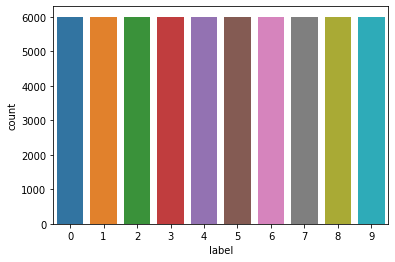

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64


In [0]:
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')
print(f'train data shape: {train.shape} \ntest data shape: {test.shape}')

y_train = train['label']
X_train = train.drop('label', axis =1)
y_test = test['label']
X_test = test.drop('label',axis =1) 


#interpret labels
sns.countplot(y_train)
plt.show()
print(y_train.value_counts())

#Data splitting and preparing 

In [0]:
#Normalization 
X_train = X_train/255.
X_test = X_test/255.

#reshape
X_train = X_train.to_numpy().reshape(-1,28,28,1)
X_test = X_test.to_numpy().reshape(-1,28,28,1)

#label encoding 
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

#Data splitting
X_train , X_val , y_train , y_val = train_test_split(X_train,y_train,test_size =0.1,random_state  = 2)

In [0]:
print(f'X_train shape = {X_train.shape}\nX_val shape= {X_val.shape}\nX_test shape = {X_test.shape}' )


X_train shape = (54000, 28, 28, 1)
X_val shape= (6000, 28, 28, 1)
X_test shape = (10000, 28, 28, 1)


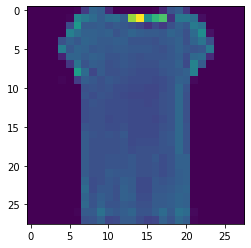

In [0]:
#show example
plt.imshow(X_train[15,:,:,0])

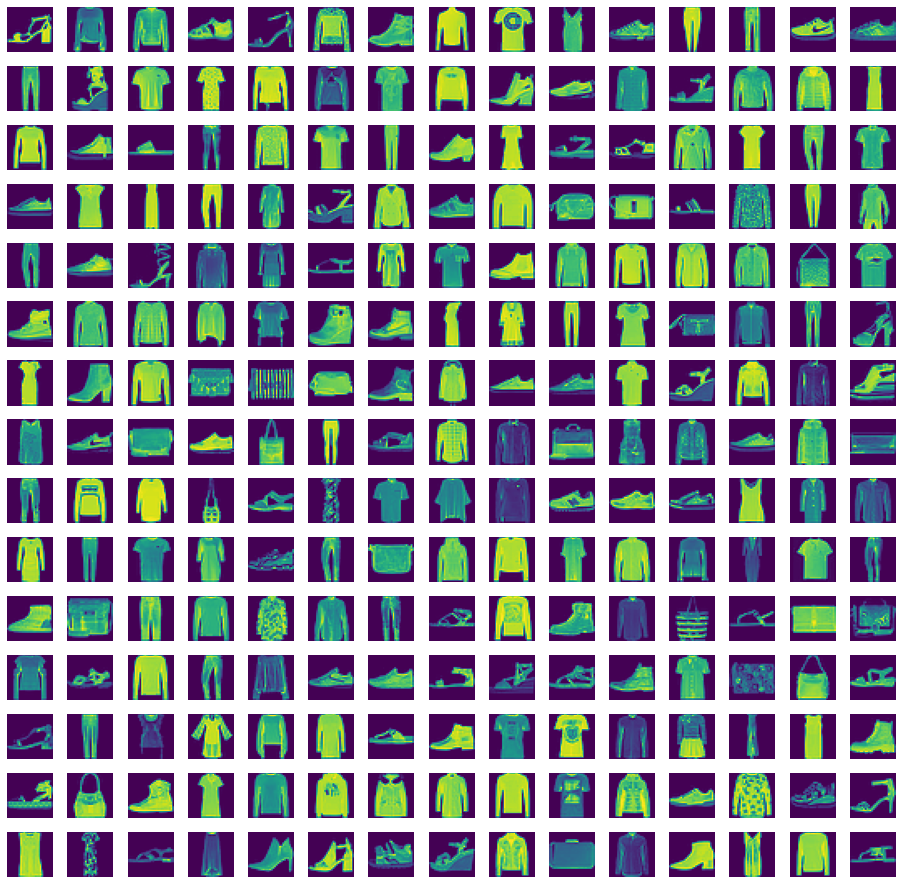

In [0]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (16,16))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow( X_train[index,:,:,0])
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.3)

#Data Augmentation

In [0]:
datagen = ImageDataGenerator(rotation_range= 30,
                             width_shift_range = 0.15,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.1,
                             fill_mode = 'nearest',
                             horizontal_flip = True)

###Callback class to stop training at ACCURACY THRESHOLD

In [0]:
ACCURACY_THRESHOLD = 0.995
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
          print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
          self.model.stop_training = True
callbacks = myCallback()

#CNN Model

In [0]:
model = tf.keras.models.Sequential([layers.Conv2D(filters = 16, kernel_size=(3,3),padding = 'same', input_shape = (28,28,1),activation = 'relu'),
                                    layers.Conv2D(filters = 16, kernel_size=(3,3),padding = 'same',activation = 'relu'),
                                    layers.MaxPooling2D(2,2),
                                    layers.Dropout(0.2),

                                    layers.Conv2D(filters = 32, kernel_size=(3,3),padding = 'same',activation = 'relu'),
                                    layers.Conv2D(filters = 32, kernel_size=(3,3),padding = 'same',activation = 'relu'),
                                    layers.MaxPooling2D(2,2),
                                    layers.Dropout(0.2),

                                    layers.Conv2D(filters = 64, kernel_size=(3,3),padding = 'same',activation = 'relu'),
                                    layers.Conv2D(filters = 64, kernel_size=(3,3),padding = 'same',activation = 'relu'),
                                    layers.MaxPooling2D(2,2),
                                    layers.Dropout(0.2),


                                    layers.Flatten(),
                                    layers.Dense(units = 1024, activation = 'relu'),
                                    layers.Dropout(0.3),
                                    layers.Dense(units = 10, activation = 'softmax')


                                    ])

model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 32)         

#Fitting the Data 


In [0]:
history = [0]*10
train_gen = datagen.flow(x = X_train,y=y_train,batch_size=256)
history[0] = model.fit(train_gen,
                              epochs =40,validation_data = (X_val,y_val) ,steps_per_epoch = 211,
)

Epoch 1/40
211/211 [==============================] - 13s 61ms/step - loss: 1.1307 - accuracy: 0.5756 - val_loss: 0.6139 - val_accuracy: 0.7648
Epoch 2/40
211/211 [==============================] - 13s 60ms/step - loss: 0.7433 - accuracy: 0.7208 - val_loss: 0.5908 - val_accuracy: 0.7697
Epoch 3/40
211/211 [==============================] - 13s 60ms/step - loss: 0.6627 - accuracy: 0.7482 - val_loss: 0.5343 - val_accuracy: 0.7942
Epoch 4/40
211/211 [==============================] - 13s 59ms/step - loss: 0.6221 - accuracy: 0.7634 - val_loss: 0.5155 - val_accuracy: 0.7963
Epoch 5/40
211/211 [==============================] - 13s 60ms/step - loss: 0.5865 - accuracy: 0.7762 - val_loss: 0.5063 - val_accuracy: 0.8093
Epoch 6/40
211/211 [==============================] - 13s 60ms/step - loss: 0.5582 - accuracy: 0.7895 - val_loss: 0.4301 - val_accuracy: 0.8382
Epoch 7/40
211/211 [==============================] - 13s 60ms/step - loss: 0.5315 - accuracy: 0.7989 - val_loss: 0.4085 - val_accuracy:

In [0]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2569 - accuracy: 0.9046


[0.2568865120410919, 0.9046000242233276]

Plotting Acuracy and Loss of Training and validation 

<Figure size 432x288 with 0 Axes>

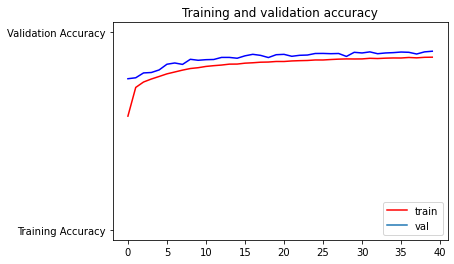

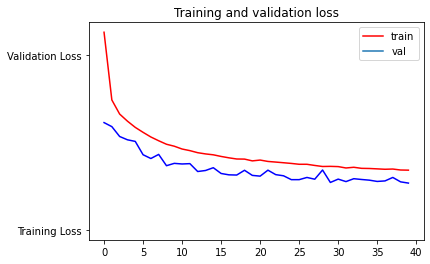

<Figure size 432x288 with 0 Axes>

In [0]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history[0].history['accuracy']
val_acc=history[0].history['val_accuracy']
loss=history[0].history['loss']
val_loss=history[0].history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(['train','val'])
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.legend(['train','val'])
plt.title('Training and validation loss')
plt.figure()



Save the weights

In [0]:
model.save_weights('my_model_weights.h5')

predict the results for kaggel submission

In [0]:
results = model.predict(X_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)


In [0]:
#download the file of submission to local
from google.colab import files

files.download('cnn_mnist_datagen.csv')
files.download('my_model_weights.h5')